# Movie Recommender System

    author: Roman Makarov
    e-mail: o.makarov@innopolis.university

## Retrieving the data

Downloading the dataset from the website

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip

--2023-11-28 17:25:23--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  10.3MB/s    in 0.5s    

2023-11-28 17:25:24 (10.3 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]



Unzipping the dataset

In [2]:
%%capture
!unzip ml-100k.zip

## Installing required libraries and importing modules

In [3]:
%%capture
!pip install torch_geometric

In [4]:
import random
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

## Defining device for faster training

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Dataset and Preprocessing

Reading the dataset

In [6]:
columns_name=['user_id','item_id','rating','timestamp']
df = pd.read_csv("ml-100k/u.data", sep="\t", names=columns_name)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Using only high ratings as interactions in order to predict which movies a user will enjoy watching next.

In [7]:
df = df[df['rating']>=3]
print(len(df))

82520


Splitting the dataset to train and test

In [8]:
train, test = train_test_split(df.values, test_size=0.2, random_state=42)
train_df = pd.DataFrame(train, columns=df.columns)
test_df = pd.DataFrame(test, columns=df.columns)

Relabeling users and movies ids to ensure they are continuous

In [9]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train_df['user_id_idx'] = le_user.fit_transform(train_df['user_id'].values)
train_df['item_id_idx'] = le_item.fit_transform(train_df['item_id'].values)

Leaving only those ids that are present in the train set and transforming them in the same way

In [10]:
train_user_ids = train_df['user_id'].unique()
train_item_ids = train_df['item_id'].unique()

test_df = test_df[
    (test_df['user_id'].isin(train_user_ids)) & \
    (test_df['item_id'].isin(train_item_ids))
]

test_df['user_id_idx'] = le_user.transform(test_df['user_id'].values)
test_df['item_id_idx'] = le_item.transform(test_df['item_id'].values)

Printing resulting statistics

In [11]:
n_users = train_df['user_id_idx'].nunique()
n_items = train_df['item_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  943
Number of unique Items :  1547


### Minibatch Sampling

Creating and testing a function for minibatch sampling

In [12]:
def data_loader(data, batch_size, n_usr, n_itm):

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    indices = [x for x in range(n_usr)]

    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)

    users.sort()
    users_df = pd.DataFrame(users, columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(list(users)).to(device),
        torch.LongTensor(list(pos_items)).to(device) + n_usr,
        torch.LongTensor(list(neg_items)).to(device) + n_usr
    )

data_loader(train_df, 16, n_users, n_items)

(tensor([ 19,  82,  90, 136, 177, 193, 197, 240, 406, 465, 620, 629, 641, 672,
         724, 818], device='cuda:0'),
 tensor([1152, 1312, 1040, 1125, 1413, 1101, 1133, 1212, 1059, 1287,  995, 1622,
         1405, 1211, 1269, 1244], device='cuda:0'),
 tensor([2360, 1183, 1066, 2027, 1553, 1159, 1466, 2160, 2331, 1557, 1464, 1400,
         2364, 2283,  997, 1404], device='cuda:0'))

## Edge Index

Including each edge twice to simulate undirected graph and changing the distribution of items ids so that each id is unique

In [13]:
u_t = torch.LongTensor(train_df.user_id_idx)
i_t = torch.LongTensor(train_df.item_id_idx) + n_users

train_edge_index = torch.stack((
    torch.cat([u_t, i_t]),
    torch.cat([i_t, u_t])
)).to(device)

train_edge_index

tensor([[ 108,  435,  863,  ..., 1242, 1380, 1542],
        [1099, 1490, 1499,  ...,  811,  187,  298]], device='cuda:0')

Let's confirm that the first and last edges match the middle two edges, but with the order of nodes swapped.

In [14]:
assert train_edge_index[:,-1].cpu().numpy()[::-1].all() == train_edge_index[:, len(train)-1].cpu().numpy().all()
assert train_edge_index[:, 0].cpu().numpy()[::-1].all() == train_edge_index[:, len(train)].cpu().numpy().all()

## Model Architecture

### LightGCN Convolutional Layer

Creating a class for a single LightGCN convolutional layer

In [15]:
class LightGCNConv(MessagePassing):
    def __init__(self, **kwargs):
        super().__init__(aggr='add')

    def forward(self, x, edge_index):
        # Compute normalization
        from_, to_ = edge_index
        deg = degree(to_, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

        # Start propagating messages (no update after aggregation)
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

### Recommender System GNN

Creating a wrapper class for LightGCN

In [16]:
class RecSysGNN(nn.Module):
    def __init__(
        self,
        latent_dim,
        num_layers,
        num_users,
        num_items
    ):
        super(RecSysGNN, self).__init__()
        self.embedding = nn.Embedding(num_users + num_items, latent_dim)
        self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))
        self.init_parameters()

    def init_parameters(self):
        # Authors of LightGCN report higher results with normal initialization
        nn.init.normal_(self.embedding.weight, std=0.1)

    def forward(self, edge_index):
        emb0 = self.embedding.weight
        embs = [emb0]

        emb = emb0
        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        out = (
            torch.mean(torch.stack(embs, dim=0), dim=0)
        )

        return emb0, out


    def encode_minibatch(self, users, pos_items, neg_items, edge_index):
        emb0, out = self(edge_index)
        return (
            out[users],
            out[pos_items],
            out[neg_items],
            emb0[users],
            emb0[pos_items],
            emb0[neg_items]
        )

## Loss function and metrics

We implement both the Bayesian Personalized Ranking loss function for a single minibatch of users, positive items, and negative items, as well as the precision@K and recall@K metrics.

Implementating BPR, precision@K, recall@K, NDCG & MAP

In [17]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
    # compute loss from initial embeddings, used for regulization
    reg_loss = (1 / 2) * (
        user_emb0.norm().pow(2) +
        pos_emb0.norm().pow(2)  +
        neg_emb0.norm().pow(2)
    ) / float(len(users))

    # compute BPR loss from user, positive item, and negative item embeddings
    pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
    neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

    bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

    return bpr_loss, reg_loss

In [18]:
def convert_to_sparse_tensor(dok_mtrx):
    dok_mtrx_coo = dok_mtrx.tocoo().astype(np.float32)
    values = dok_mtrx_coo.data
    indices = np.vstack((dok_mtrx_coo.row, dok_mtrx_coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = dok_mtrx_coo.shape

    dok_mtrx_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

    return dok_mtrx_sparse_tensor

In [19]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
    user_Embedding = nn.Embedding(user_Embed_wts.size()[0], user_Embed_wts.size()[1], _weight = user_Embed_wts)
    item_Embedding = nn.Embedding(item_Embed_wts.size()[0], item_Embed_wts.size()[1], _weight = item_Embed_wts)

    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())

    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

    R = sp.dok_matrix((n_users, n_items), dtype = np.float32)
    R[train_data['user_id_idx'], train_data['item_id_idx']] = 1.0

    R_tensor = convert_to_sparse_tensor(R)
    R_tensor_dense = R_tensor.to_dense()

    R_tensor_dense = R_tensor_dense*(-np.inf)
    R_tensor_dense = torch.nan_to_num(R_tensor_dense, nan=0.0).to(device)

    relevance_score = relevance_score+R_tensor_dense

    topk_relevance_score = torch.topk(relevance_score, K).values
    topk_relevance_indices = torch.topk(relevance_score, K).indices

    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])

    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index

    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

    test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

    metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]


    metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1)
    metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

    def get_hit_list(item_id_idx, top_rlvnt_itm):
        return [1 if x in set(item_id_idx) else 0 for x in top_rlvnt_itm ]

    metrics_df['hit_list'] = metrics_df.apply(lambda x : get_hit_list(x['item_id_idx'], x['top_rlvnt_itm']), axis = 1)

    def get_dcg_idcg(item_id_idx, hit_list):
        idcg  = sum([1 / np.log1p(idx+1) for idx in range(min(len(item_id_idx),len(hit_list)))])
        dcg =  sum([hit / np.log1p(idx+1) for idx, hit in enumerate(hit_list)])
        return dcg/idcg

    def get_cumsum(hit_list):
        return np.cumsum(hit_list)

    def get_map(item_id_idx, hit_list, hit_list_cumsum):
        return sum([hit_cumsum*hit/(idx+1) for idx, (hit, hit_cumsum) in enumerate(zip(hit_list, hit_list_cumsum))])/len(item_id_idx)

    metrics_df['ndcg'] = metrics_df.apply(lambda x : get_dcg_idcg(x['item_id_idx'], x['hit_list']), axis = 1)
    metrics_df['hit_list_cumsum'] = metrics_df.apply(lambda x : get_cumsum(x['hit_list']), axis = 1)

    metrics_df['map'] = metrics_df.apply(lambda x : get_map(x['item_id_idx'], x['hit_list'], x['hit_list_cumsum']), axis = 1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean(), metrics_df['ndcg'].mean(), metrics_df['map'].mean()

## Train and evaluate models

Now that we've implemented both LightGCN and NGCF in PyG, we can train and evaluate their performance!

In [20]:
latent_dim = 64
n_layers = 3

EPOCHS = 50
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005
K = 20

In [21]:
def train_and_eval(model, optimizer, train_df):
    loss_list_epoch = []
    bpr_loss_list_epoch = []
    reg_loss_list_epoch = []

    recall_list = []
    precision_list = []
    ndcg_list = []
    map_list = []

    for epoch in tqdm(range(EPOCHS)):
        n_batch = int(len(train)/BATCH_SIZE)

        final_loss_list = []
        bpr_loss_list = []
        reg_loss_list = []

        model.train()
        for batch_idx in range(n_batch):
            optimizer.zero_grad()

            users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
            users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

            bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
            )
            reg_loss = DECAY * reg_loss
            final_loss = bpr_loss + reg_loss

            final_loss.backward()
            optimizer.step()

            final_loss_list.append(final_loss.item())
            bpr_loss_list.append(bpr_loss.item())
            reg_loss_list.append(reg_loss.item())

        model.eval()
        with torch.no_grad():
            _, out = model(train_edge_index)
            final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
            test_topK_recall,  test_topK_precision, test_topK_ndcg, test_topK_map = get_metrics(
            final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, K
            )

        loss_list_epoch.append(round(np.mean(final_loss_list),4))
        bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
        reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

        recall_list.append(round(test_topK_recall,4))
        precision_list.append(round(test_topK_precision,4))
        ndcg_list.append(round(test_topK_ndcg,4))
        map_list.append(round(test_topK_map,4))

    return (
        loss_list_epoch,
        bpr_loss_list_epoch,
        reg_loss_list_epoch,
        recall_list,
        precision_list,
        ndcg_list,
        map_list
    )

### Train and eval LightGCN

In [22]:
lightgcn = RecSysGNN(
  latent_dim=latent_dim,
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_items,
).to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

Size of Learnable Embedding :  [torch.Size([2490, 64])]


In [23]:
light_loss, light_bpr, light_reg, light_recall, light_precision, light_ndcg, light_map = train_and_eval(lightgcn, optimizer, train_df)

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-18-bd70914e2cfe>:10: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  dok_mtrx_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))


In [24]:
epoch_list = [(i+1) for i in range(EPOCHS)]

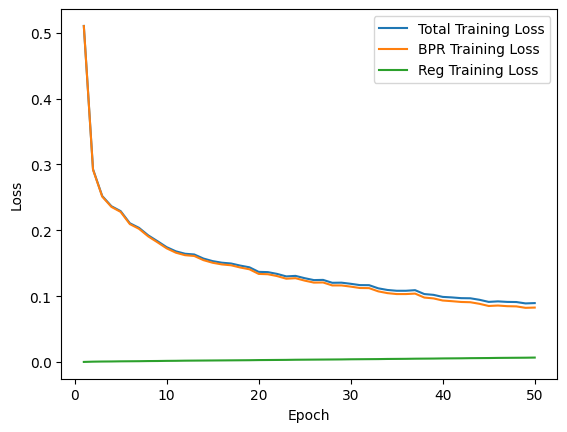

In [25]:
plt.plot(epoch_list, light_loss, label='Total Training Loss')
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')
plt.plot(epoch_list, light_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

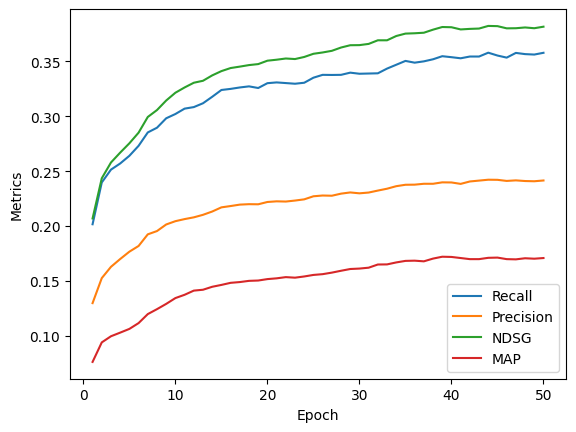

In [26]:
plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')
plt.plot(epoch_list, light_ndcg, label='NDSG')
plt.plot(epoch_list, light_map, label='MAP')

plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

## References

I thank the authors of the following sources, from which parts of this solution were inspired or adapted.

- https://medium.com/stanford-cs224w/recommender-systems-with-gnns-in-pyg-d8301178e377

- https://www.kaggle.com/dipanjandas96/lightgcn-pytorch-from-scratch

- https://github.com/gusye1234/LightGCN-PyTorch

- https://github.com/SytzeAndr/NGCF_RP32/blob/hand-in/NGCF.ipynb
